In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import os
import re
import pickle
import numpy as np
import h5py

Using TensorFlow backend.


### Set GPU memory limit

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

### Training parameters

In [3]:
batch_size = 64
# num_classes = 2
epochs = 20
data_augmentation = False
num_predictions = 20 ## Chia-Ching: ??
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'model_solarpanel_01.h5'

### Read images and split them into training/testing sets

In [4]:
# # The data, shuffled and split between train and test sets:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
import glob
from PIL import Image
from sklearn.model_selection import train_test_split

data_dir = '../solar_with_dataaug_patch100_groupby'

img_path_other = glob.glob(data_dir + '/other' + "/*")
img_path_solar = glob.glob(data_dir + '/solar' + "/*")

## take original solar images (before augmentation)
solar_original = list(set([re.split("_aug_|\\.", os.path.basename(item))[0] for item in img_path_solar]))

## Split solar images into training / testing sets
solar_original_train, solar_original_test = train_test_split(solar_original, test_size = 0.2)

## Expand training solar images with their augmented images
solar_train_all = [item for item in img_path_solar \
                   if re.split("_aug_|\\.", os.path.basename(item))[0] in solar_original_train]
## For testing solar images, just use the original images
solar_test_all = [os.path.join(data_dir + '/solar/' + item + '.jpg') for item in solar_original_test]

## read solar images into memory
img_solar_train = np.array([np.array(Image.open(p), 'f') for p in solar_train_all])
img_solar_test = np.array([np.array(Image.open(p), 'f') for p in solar_test_all])

## read other images into memory
other_train_all, other_test_all = train_test_split(img_path_other,
                                                   train_size = len(solar_train_all),
                                                   test_size = len(solar_test_all))
img_other_train = np.array([np.array(Image.open(p), 'f') for p in other_train_all])
img_other_test = np.array([np.array(Image.open(p), 'f') for p in other_test_all])

print(img_other_train.shape)
print(img_other_test.shape)
print(img_solar_train.shape)
print(img_solar_test.shape)

(5580, 100, 100, 3)
(45, 100, 100, 3)
(5580, 100, 100, 3)
(45, 100, 100, 3)


### Plot some images

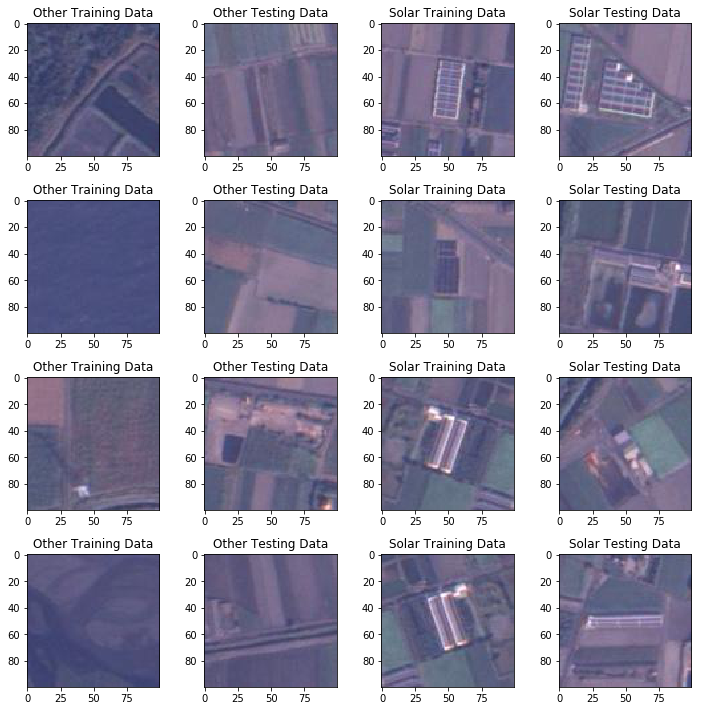

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(4, 4, figsize=(10,10))
fig.tight_layout(h_pad=1.0)

for i, ax in enumerate(axes):
    ax[0].set_title("Other Training Data")
    ax[1].set_title("Other Testing Data")
    ax[2].set_title("Solar Training Data")
    ax[3].set_title("Solar Testing Data")
    ax[0].imshow((img_other_train[i].astype('uint8')))
    ax[1].imshow((img_other_test[i].astype('uint8')))
    ax[2].imshow((img_solar_train[i].astype('uint8')))
    ax[3].imshow((img_solar_test[i].astype('uint8')))

### Create labels and merge other/solar data

In [6]:
y_other_train = np.zeros(img_other_train.shape[0])
y_other_test = np.zeros(img_other_test.shape[0])
y_solar_train = np.ones(img_solar_train.shape[0])
y_solar_test = np.ones(img_solar_test.shape[0])

x_train = np.concatenate((img_other_train, img_solar_train), axis = 0)
y_train = np.concatenate((y_other_train, y_solar_train), axis = 0)
x_test = np.concatenate((img_other_test, img_solar_test), axis = 0)
y_test = np.concatenate((y_other_test, y_solar_test), axis = 0)

# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11160, 100, 100, 3)
(11160,)
(90, 100, 100, 3)
(90,)


### Construct model

In [7]:
model = Sequential()

model.add(Conv2D(32, (5, 5), padding='same', ## Chia-Ching: change from (3, 3) to (5, 5)
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (5, 5))) ## Chia-Ching: change from (3, 3) to (5, 5)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), padding='same')) ## Chia-Ching: change from (3, 3) to (5, 5)
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5))) ## Chia-Ching: change from (3, 3) to (5, 5)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1)) ## Chia-Ching: change from 'num_classes' to 1
model.add(Activation('sigmoid')) ## Chia-Ching: change from 'softmax' to 'sigmoid'

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      2432      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        51264     
__________

### Specify early-stop callback, optimizer, and metric

In [8]:
from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy', ## Chia-Ching: change from 'categorical_crossentropy' to 'binary_crossentropy'
              optimizer=opt,
              metrics=['accuracy'])

### Shuffle (execute only once!)

In [9]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

## debug
# y_train[0:5]
# fig, axes = plt.subplots(5, 1, figsize=(24,12))
# fig.tight_layout(h_pad=1.0)
# for i, ax in enumerate(axes):
#     ax.imshow((x_train[i]))

### Training

In [10]:
if not data_augmentation:
    print('Not using data augmentation.')
    hist_no_aug = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=0.2,
                            shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    hist_aug = model.fit_generator(datagen.flow(x_train, y_train,
                                                batch_size=batch_size),
                                   steps_per_epoch=x_train.shape[0] // batch_size,
                                   epochs=epochs,
                                   validation_data=(x_test, y_test),
                                   workers=4)

Not using data augmentation.
Train on 8928 samples, validate on 2232 samples
Epoch 1/20
8928/8928 [==============================] - 11s - loss: 5.4878 - acc: 0.5532 - val_loss: 2.0051 - val_acc: 0.6761
Epoch 2/20
8928/8928 [==============================] - 9s - loss: 1.8571 - acc: 0.6471 - val_loss: 0.5236 - val_acc: 0.7030
Epoch 3/20
8928/8928 [==============================] - 9s - loss: 0.5859 - acc: 0.7091 - val_loss: 0.5403 - val_acc: 0.7030
Epoch 4/20
8928/8928 [==============================] - 9s - loss: 0.4551 - acc: 0.7889 - val_loss: 0.4117 - val_acc: 0.7791
Epoch 5/20
8928/8928 [==============================] - 9s - loss: 0.3875 - acc: 0.8271 - val_loss: 0.3240 - val_acc: 0.8696
Epoch 6/20
8928/8928 [==============================] - 9s - loss: 0.3592 - acc: 0.8460 - val_loss: 0.3607 - val_acc: 0.8401
Epoch 7/20
8928/8928 [==============================] - 9s - loss: 0.3290 - acc: 0.8647 - val_loss: 0.3092 - val_acc: 0.8656
Epoch 8/20
8928/8928 [=========================

### Learning curve

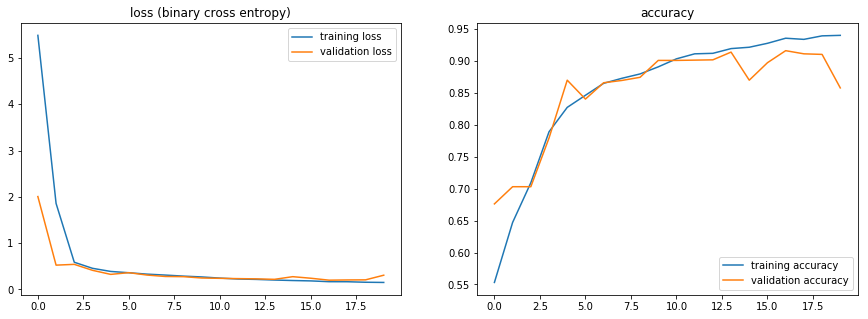

In [11]:
loss_train = hist_no_aug.history.get("loss")
loss_valid = hist_no_aug.history.get("val_loss")
acc_train = hist_no_aug.history.get("acc")
acc_valid = hist_no_aug.history.get("val_acc")

fig, axes = plt.subplots(1, 2, figsize=(15,5))
# fig.tight_layout(h_pad=1.0)

axes[0].set_title("loss (binary cross entropy)")
axes[0].plot(range(len(loss_train)), loss_train, label='training loss')
axes[0].plot(range(len(loss_valid)), loss_valid, label='validation loss')
axes[0].legend(loc=1)

axes[1].set_title("accuracy")
axes[1].plot(range(len(acc_train)), acc_train, label='training accuracy')
axes[1].plot(range(len(acc_valid)), acc_valid, label='validation accuracy')
axes[1].legend(loc=4)

### Prediction

In [12]:
y_hat = model.predict_classes(x_test, batch_size=batch_size)

90/90 [==============================] - 0s     


### Compute metrics

In [13]:
y_TP = [(y_test[i] == y_hat[i] and y_hat[i] == 1) for i in range(len(y_test))]
y_FP = [(y_test[i] != y_hat[i] and y_hat[i] == 1) for i in range(len(y_test))]
y_FN = [(y_test[i] != y_hat[i] and y_hat[i] == 0) for i in range(len(y_test))]
y_TN = [(y_test[i] == y_hat[i] and y_hat[i] == 0) for i in range(len(y_test))]
print('True Positive: %d'%(sum(y_TP)))
print('False Positive: %d'%(sum(y_FP)))
print('False Negative: %d'%(sum(y_FN)))
print('True Negative: %d'%(sum(y_TN)))
precision = sum(y_TP) / float(sum(y_TP) + sum(y_FP))
print('Precision: %.4f'%(precision))
recall = sum(y_TP) / float(sum(y_TP) + sum(y_FN))
print('Recall: %.4f'%(recall))
print('F1-score: %.4f'%(2 * precision * recall / (precision + recall)))
print('Accuracy: %.4f'%((sum(y_TP) + sum(y_TN)) / float(len(y_test))))

True Positive: 32
False Positive: 1
False Negative: 13
True Negative: 44
Precision: 0.9697
Recall: 0.7111
F1-score: 0.8205
Accuracy: 0.8444


### Predict again with more other images than solar images (9:1)

In [14]:
## read other images into memory
other_test_all2 = [item for item in img_path_other if not item in other_train_all]
other_test_all2 = np.random.choice(other_test_all2, 9 * len(solar_test_all))
img_other_test2 = np.array([np.array(Image.open(p), 'f') for p in other_test_all2])

y_other_test2 = np.zeros(img_other_test2.shape[0])
x_test2 = np.concatenate((img_other_test2, img_solar_test), axis = 0)
y_test2 = np.concatenate((y_other_test2, y_solar_test), axis = 0)

print(x_test2.shape)
print(y_test2.shape)

(450, 100, 100, 3)
(450,)


In [15]:
y_hat2 = model.predict_classes(x_test2, batch_size=batch_size)

448/450 [============================>.] - ETA: 0s

In [16]:
y_TP2 = [(y_test2[i] == y_hat2[i] and y_hat2[i] == 1) for i in range(len(y_test2))]
y_FP2 = [(y_test2[i] != y_hat2[i] and y_hat2[i] == 1) for i in range(len(y_test2))]
y_FN2 = [(y_test2[i] != y_hat2[i] and y_hat2[i] == 0) for i in range(len(y_test2))]
y_TN2 = [(y_test2[i] == y_hat2[i] and y_hat2[i] == 0) for i in range(len(y_test2))]
print('True Positive: %d'%(sum(y_TP2)))
print('False Positive: %d'%(sum(y_FP2)))
print('False Negative: %d'%(sum(y_FN2)))
print('True Negative: %d'%(sum(y_TN2)))
precision2 = sum(y_TP2) / float(sum(y_TP2) + sum(y_FP2))
print('Precision: %.4f'%(precision2))
recall2 = sum(y_TP2) / float(sum(y_TP2) + sum(y_FN2))
print('Recall: %.4f'%(recall2))
print('F1-score: %.4f'%(2 * precision2 * recall2 / (precision2 + recall2)))
print('Accuracy: %.4f'%((sum(y_TP2) + sum(y_TN2)) / float(len(y_test2))))

True Positive: 32
False Positive: 8
False Negative: 13
True Negative: 397
Precision: 0.8000
Recall: 0.7111
F1-score: 0.7529
Accuracy: 0.9533


### Predict again with more other images than solar images (1420:45)

In [17]:
other_test_all3 = [item for item in img_path_other if not item in other_train_all]
img_other_test3 = np.array([np.array(Image.open(p), 'f') for p in other_test_all3])

y_other_test3 = np.zeros(img_other_test3.shape[0])
x_test3 = np.concatenate((img_other_test3, img_solar_test), axis = 0)
y_test3 = np.concatenate((y_other_test3, y_solar_test), axis = 0)

print(x_test3.shape)
print(y_test3.shape)

(1465, 100, 100, 3)
(1465,)


In [18]:
y_hat3 = model.predict_classes(x_test3, batch_size=batch_size)

1465/1465 [==============================] - 0s     


In [19]:
y_TP3 = [(y_test3[i] == y_hat3[i] and y_hat3[i] == 1) for i in range(len(y_test3))]
y_FP3 = [(y_test3[i] != y_hat3[i] and y_hat3[i] == 1) for i in range(len(y_test3))]
y_FN3 = [(y_test3[i] != y_hat3[i] and y_hat3[i] == 0) for i in range(len(y_test3))]
y_TN3 = [(y_test3[i] == y_hat3[i] and y_hat3[i] == 0) for i in range(len(y_test3))]
print('True Positive: %d'%(sum(y_TP3)))
print('False Positive: %d'%(sum(y_FP3)))
print('False Negative: %d'%(sum(y_FN3)))
print('True Negative: %d'%(sum(y_TN3)))
precision3 = sum(y_TP3) / float(sum(y_TP3) + sum(y_FP3))
print('Precision: %.4f'%(precision3))
recall3 = sum(y_TP3) / float(sum(y_TP3) + sum(y_FN3))
print('Recall: %.4f'%(recall3))
print('F1-score: %.4f'%(2 * precision3 * recall3 / (precision3 + recall3)))
print('Accuracy: %.4f'%((sum(y_TP3) + sum(y_TN3)) / float(len(y_test3))))

True Positive: 32
False Positive: 23
False Negative: 13
True Negative: 1397
Precision: 0.5818
Recall: 0.7111
F1-score: 0.6400
Accuracy: 0.9754


### Save model and weights

In [20]:
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

### Evaluation

In [21]:
# # Evaluate model with test data set and share sample prediction results

# print('Model Accuracy = %.2f' % (evaluation[1]))

# predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
#                                                    batch_size=batch_size,
#                                                    shuffle=False),
#                                       steps=x_test.shape[0] // batch_size,
#                                       workers=4)

# for predict_index, predicted_y in enumerate(predict_gen):
#     actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
#     predicted_label = labels['label_names'][np.argmax(predicted_y)]
#     print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
#                                                           predicted_label))
#     if predict_index == num_predictions:
#         break